In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brain-nd5/Brain MRI ND-5 Dataset/tumordata/Training/no_tumor/healthy (125).jpg
/kaggle/input/brain-nd5/Brain MRI ND-5 Dataset/tumordata/Training/no_tumor/NoTumor_train_670.jpg
/kaggle/input/brain-nd5/Brain MRI ND-5 Dataset/tumordata/Training/no_tumor/NoTumor_train_5007.jpg
/kaggle/input/brain-nd5/Brain MRI ND-5 Dataset/tumordata/Training/no_tumor/NoTumor_train_1393.jpg
/kaggle/input/brain-nd5/Brain MRI ND-5 Dataset/tumordata/Training/no_tumor/NoTumor_train_3809.jpg
/kaggle/input/brain-nd5/Brain MRI ND-5 Dataset/tumordata/Training/no_tumor/NoTumor_train_2832.jpg
/kaggle/input/brain-nd5/Brain MRI ND-5 Dataset/tumordata/Training/no_tumor/NoTumor_train_4981.jpg
/kaggle/input/brain-nd5/Brain MRI ND-5 Dataset/tumordata/Training/no_tumor/NoTumor_train_3680.jpg
/kaggle/input/brain-nd5/Brain MRI ND-5 Dataset/tumordata/Training/no_tumor/NoTumor_train_6988.jpg
/kaggle/input/brain-nd5/Brain MRI ND-5 Dataset/tumordata/Training/no_tumor/NoTumor_train_1020.jpg
/kaggle/input/brain-nd5/Br

In [5]:
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import timm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [6]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-5
NUM_CLASSES = 4  
IMG_SIZE = 224

DATA_ROOT = "/kaggle/input/brain-nd5/Brain MRI ND-5 Dataset/tumordata"
TRAIN_DIR = os.path.join(DATA_ROOT, "Training")
TEST_DIR = os.path.join(DATA_ROOT, "Testing")

# Data Preprocessing
# Probabilistic CLAHE 
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), p=0.4):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.p = p

    def __call__(self, img):
        # img is a PIL image
        if np.random.rand() > self.p:
            return img
        im = np.array(img)  # RGB uint8
        # apply CLAHE on L channel in LAB
        lab = cv2.cvtColor(im, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        l2 = clahe.apply(l)
        lab2 = cv2.merge([l2, a, b])
        out = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
        return transforms.functional.to_pil_image(out)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    CLAHETransform(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# primary training folder
full_train_ds = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)

# Train (80%) and Val (20%)
train_len = int(0.80 * len(full_train_ds))
val_len = len(full_train_ds) - train_len
train_ds, val_ds = random_split(full_train_ds, [train_len, val_len])

# Testing folder
test_ds = datasets.ImageFolder(root=TEST_DIR, transform=transform)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Classes found: {full_train_ds.classes}")
print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)} | Test size: {len(test_ds)}")


Classes found: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Train size: 11141 | Val size: 2786 | Test size: 3961


In [7]:
# Model Setup: ConvNeXtV2-Tiny (FCMAE pre-trained) + ECA + Lite-ASPP + GeM

class ECABlock(nn.Module):
    def __init__(self, channels: int, k_size: int = 3):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv1d = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)                       # (B, C, 1, 1)
        y = y.squeeze(-1).transpose(1, 2)          # (B, 1, C)
        y = self.conv1d(y)                         # (B, 1, C)
        y = y.transpose(1, 2).unsqueeze(-1)        # (B, C, 1, 1)
        y = self.sigmoid(y)
        return x * y

class GeM(nn.Module):
    def __init__(self, p: float = 3.0, eps: float = 1e-6, learn_p: bool = True):
        super().__init__()
        self.eps = eps
        self.p = nn.Parameter(torch.ones(1) * p) if learn_p else torch.tensor([p])

    def forward(self, x):
        x = x.clamp(min=self.eps).pow(self.p)
        x = nn.functional.adaptive_avg_pool2d(x, 1)
        x = x.pow(1.0 / self.p)
        return x

class LiteASPP(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, dilations=(1, 2, 4), dropout: float = 0.1):
        super().__init__()
        assert len(dilations) == 3

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.GELU()
        )

        def dbranch(d):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=d, dilation=d, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.GELU()
            )

        self.branch2 = dbranch(dilations[0])
        self.branch3 = dbranch(dilations[1])
        self.branch4 = dbranch(dilations[2])

        self.project = nn.Sequential(
            nn.Conv2d(out_ch * 4, out_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.GELU(),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        y = torch.cat([b1, b2, b3, b4], dim=1)
        return self.project(y)

class ConvNeXtV2_Boosted(nn.Module):
    def __init__(
        self,
        backbone_name="convnextv2_tiny.fcmae_ft_in1k",
        num_classes=NUM_CLASSES,
        pretrained=True,
        use_eca=True,
        use_aspp=True,
        aspp_out_ch=128,
        aspp_dilations=(1, 2, 4),
        use_gem=True,
        dropout=0.4,
        eca_k=3,
    ):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=pretrained,
            num_classes=0,   # remove classifier
            global_pool=""   # keep spatial map
        )

        # infer channels
        with torch.no_grad():
            dummy = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
            feat = self.backbone(dummy)
            in_ch = feat.shape[1]

        self.eca = ECABlock(in_ch, k_size=eca_k) if use_eca else nn.Identity()
        self.aspp = LiteASPP(in_ch, aspp_out_ch, dilations=aspp_dilations, dropout=0.1) if use_aspp else nn.Identity()

        head_in = aspp_out_ch if use_aspp else in_ch
        self.pool = GeM() if use_gem else nn.AdaptiveAvgPool2d(1)

        self.head = nn.Sequential(
            nn.Flatten(1),
            nn.Dropout(dropout),
            nn.Linear(head_in, num_classes),
        )

    def forward(self, x):
        x = self.backbone(x)   # (B, C, H, W)
        x = self.eca(x)
        x = self.aspp(x)
        x = self.pool(x)       # (B, C, 1, 1)
        x = self.head(x)
        return x

model = ConvNeXtV2_Boosted().to(device)

# Optional: class-weighted CrossEntropy (helps if imbalance)
def get_class_weights_from_imagefolder(dataset: datasets.ImageFolder):
    counts = np.zeros(len(dataset.classes), dtype=np.int64)
    for _, y in dataset.samples:
        counts[y] += 1
    counts = np.maximum(counts, 1)
    w = counts.sum() / (len(counts) * counts)
    return torch.tensor(w, dtype=torch.float32)

class_weights = get_class_weights_from_imagefolder(full_train_ds).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='min',
                                                 factor=0.5,
                                                 patience=2)

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

In [8]:
scaler = torch.amp.GradScaler('cuda', enabled=torch.cuda.is_available())

best_val_loss = float('inf') 
best_model_path = 'Med-ConvMAE.pth'
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Overall Epoch Progress Bar
pbar = tqdm(range(EPOCHS), desc="Total Progress")

for epoch in pbar:
    # Training 
    model.train()
    train_loss_sum, train_correct, train_total = 0.0, 0, 0
    
    # Batch progress bar for training
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
    
    for imgs, labels in train_loader_tqdm:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss_sum += loss.item() * imgs.size(0)
        _, pred = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (pred == labels).sum().item()
        
        train_loader_tqdm.set_postfix(loss=f"{loss.item():.4f}")

    # Validation 
    model.eval()
    val_loss_sum, val_correct, val_total = 0.0, 0, 0
    
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False)
    
    with torch.no_grad():
        for imgs, labels in val_loader_tqdm:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss_sum += loss.item() * imgs.size(0)
            _, pred = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (pred == labels).sum().item()

    # Metrics 
    epoch_train_loss = train_loss_sum / max(train_total, 1)
    epoch_train_acc = 100.0 * train_correct / max(train_total, 1)
    epoch_val_loss = val_loss_sum / max(val_total, 1)
    epoch_val_acc = 100.0 * val_correct / max(val_total, 1)

    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    scheduler.step(epoch_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)
        tqdm.write(f"--> Epoch {epoch+1}: New Best Model Saved (Loss: {best_val_loss:.4f})")

    # Update overall bar with status
    pbar.set_postfix(Val_Acc=f"{epoch_val_acc:.2f}%", LR=f"{current_lr:.6f}")
    
    tqdm.write(f"Epoch {epoch+1}/{EPOCHS}: Loss [T: {epoch_train_loss:.4f}, V: {epoch_val_loss:.4f}] | "
               f"Acc [T: {epoch_train_acc:.2f}%, V: {epoch_val_acc:.2f}%]")

Total Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

--> Epoch 1: New Best Model Saved (Loss: 0.2892)
Epoch 1/10: Loss [T: 0.6811, V: 0.2892] | Acc [T: 72.79%, V: 91.46%]


Epoch 2 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

--> Epoch 2: New Best Model Saved (Loss: 0.2047)
Epoch 2/10: Loss [T: 0.2378, V: 0.2047] | Acc [T: 92.89%, V: 93.07%]


Epoch 3 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

--> Epoch 3: New Best Model Saved (Loss: 0.1027)
Epoch 3/10: Loss [T: 0.1378, V: 0.1027] | Acc [T: 96.06%, V: 97.20%]


Epoch 4 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

--> Epoch 4: New Best Model Saved (Loss: 0.0840)
Epoch 4/10: Loss [T: 0.1015, V: 0.0840] | Acc [T: 97.30%, V: 97.92%]


Epoch 5 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

--> Epoch 5: New Best Model Saved (Loss: 0.0724)
Epoch 5/10: Loss [T: 0.0814, V: 0.0724] | Acc [T: 97.98%, V: 98.17%]


Epoch 6 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

--> Epoch 6: New Best Model Saved (Loss: 0.0641)
Epoch 6/10: Loss [T: 0.0595, V: 0.0641] | Acc [T: 98.74%, V: 98.38%]


Epoch 7 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

--> Epoch 7: New Best Model Saved (Loss: 0.0482)
Epoch 7/10: Loss [T: 0.0550, V: 0.0482] | Acc [T: 98.76%, V: 98.99%]


Epoch 8 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 8/10: Loss [T: 0.0408, V: 0.0672] | Acc [T: 99.17%, V: 97.99%]


Epoch 9 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

--> Epoch 9: New Best Model Saved (Loss: 0.0444)
Epoch 9/10: Loss [T: 0.0344, V: 0.0444] | Acc [T: 99.30%, V: 99.17%]


Epoch 10 [Train]:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 10/10: Loss [T: 0.0271, V: 0.0558] | Acc [T: 99.52%, V: 98.56%]


In [9]:
model.load_state_dict(torch.load("/kaggle/working/Med-ConvMAE.pth"))
model.to(device)
model.eval()

test_correct = 0
test_total = 0
all_preds = []
all_labels = []

print("Running Final Evaluation on Test Set...")

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        # Collect for metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total

print(f"\n--- Final Test Results ---")
print(f"Test Accuracy: {test_acc:.2f}%")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=full_train_ds.classes))

Running Final Evaluation on Test Set...

--- Final Test Results ---
Test Accuracy: 96.11%

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.91      0.95      1208
meningioma_tumor       0.90      0.98      0.94       930
        no_tumor       0.97      1.00      0.98       831
 pituitary_tumor       0.99      0.98      0.98       992

        accuracy                           0.96      3961
       macro avg       0.96      0.97      0.96      3961
    weighted avg       0.96      0.96      0.96      3961



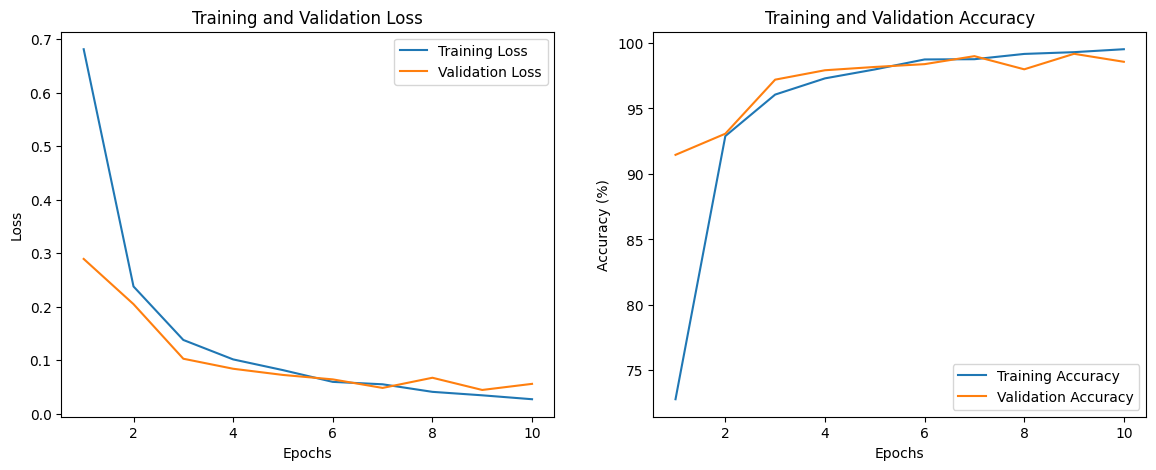

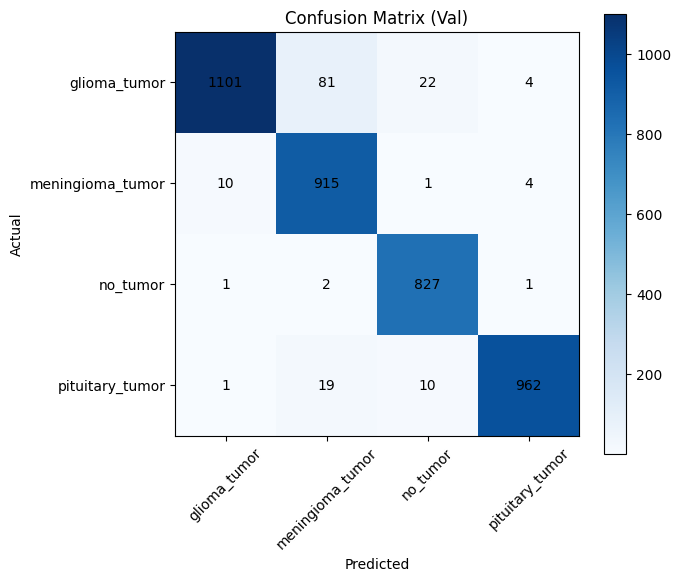

In [10]:
epochs = range(1, len(history['train_loss']) + 1)

# Loss-Accuracy & Confusion Matrix
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Training Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Plot Confusion Matrix
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        outputs = model(imgs.to(device))
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(list(preds))
        all_labels.extend(list(labels.numpy()))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Val)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(range(len(full_train_ds.classes)), full_train_ds.classes, rotation=45)
plt.yticks(range(len(full_train_ds.classes)), full_train_ds.classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()
